**FEATURE ENGINEERING AND EDA**

In [ ]:
pip install pyswarm

In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
raw_data = pd.read_csv('T1.csv')
raw_data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [ ]:
raw_data['Date/Time'] = pd.to_datetime(raw_data['Date/Time'],format="%d %m %Y %H:%M")
raw_data.set_index('Date/Time',inplace=True)
raw_data.columns = ['Power','Wind_speed','Theoretical_power','Wind_direction']

In [ ]:
raw_data['Loss'] = raw_data['Theoretical_power'] - raw_data['Power']
raw_data.head(3)

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss
Date/Time,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,36.281117
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,66.148316
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,84.523429


In [ ]:
raw_data_nm = raw_data[~((raw_data['Power']<=0) & (raw_data['Wind_speed'] > 3.3))]

In [ ]:
def x_y_component(wind_direction, wind_speed):
    radians = (wind_direction * np.pi)/180
    x = wind_speed * np.cos(radians)
    y = wind_speed * np.sin(radians)
    return x,y

In [ ]:
raw_data_nm['x_com'], raw_data_nm['y_com'] = x_y_component(raw_data_nm['Wind_direction'],raw_data_nm['Wind_speed'])

<ipython-input-8-c4d19066b4b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_nm['x_com'], raw_data_nm['y_com'] = x_y_component(raw_data_nm['Wind_direction'],raw_data_nm['Wind_speed'])
<ipython-input-8-c4d19066b4b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_nm['x_com'], raw_data_nm['y_com'] = x_y_component(raw_data_nm['Wind_direction'],raw_data_nm['Wind_speed'])


In [ ]:
hourly_nm = pd.DataFrame()
columns = ['Power','Wind_speed','Theoretical_power','Wind_direction','Loss','x_com','y_com']
for column in columns:
    hourly_nm[column] = raw_data_nm[column].resample('H').mean()

In [ ]:
for column in hourly_nm.columns:
    hourly_nm[column] = hourly_nm[column].interpolate()

In [ ]:
hourly_nm['T_1'] = hourly_nm['Power'].shift(1)

In [ ]:
hourly_nm.drop(labels=['Wind_direction'],axis=1,inplace=True)
hourly_nm = hourly_nm.dropna()
hourly_nm

,Power,Wind_speed,Theoretical_power,Loss,x_com,y_com,T_1
Date/Time,,,,,,,
2018-01-01 01:00:00,460.537125,5.644205,513.418408,52.881284,-1.068567,-5.515860,390.480362
2018-01-01 02:00:00,733.655375,6.452037,788.401310,54.745935,-0.176225,-6.440522,460.537125
2018-01-01 03:00:00,909.362081,6.811455,948.793346,39.431265,-1.652917,-6.596464,733.655375
2018-01-01 04:00:00,1393.518188,7.748749,1406.391795,12.873607,-2.912491,-7.138868,909.362081
2018-01-01 05:00:00,1149.599162,7.236854,1128.194441,-21.404721,-3.170687,-6.478943,1393.518188
...,...,...,...,...,...,...,...
2018-12-31 19:00:00,1065.438416,6.481788,884.566693,-180.871722,0.539250,6.418344,386.752182
2018-12-31 20:00:00,1629.041504,8.083644,1593.819956,-35.221548,1.432138,7.954137,1065.438416
2018-12-31 21:00:00,2135.531637,9.121862,2224.666576,89.134939,1.610638,8.978355,1629.041504


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

In [ ]:
df = pd.read_csv("hourly_nm.csv")
df

,Date/Time,Power,Wind_speed,Theoretical_power,Loss,x_com,y_com,T_1
0,2018-01-01 01:00:00,460.537125,5.644205,513.418408,52.881284,-1.068567,-5.515860,390.480362
1,2018-01-01 02:00:00,733.655375,6.452037,788.401310,54.745935,-0.176225,-6.440522,460.537125
2,2018-01-01 03:00:00,909.362081,6.811455,948.793346,39.431265,-1.652917,-6.596464,733.655375
3,2018-01-01 04:00:00,1393.518188,7.748749,1406.391795,12.873607,-2.912491,-7.138868,909.362081
4,2018-01-01 05:00:00,1149.599162,7.236854,1128.194441,-21.404721,-3.170687,-6.478943,1393.518188
...,...,...,...,...,...,...,...,...
8754,2018-12-31 19:00:00,1065.438416,6.481788,884.566693,-180.871722,0.539250,6.418344,386.752182
8755,2018-12-31 20:00:00,1629.041504,8.083644,1593.819956,-35.221548,1.432138,7.954137,1065.438416
8756,2018-12-31 21:00:00,2135.531637,9.121862,2224.666576,89.134939,1.610638,8.978355,1629.041504
8757,2018-12-31 22:00:00,3115.066203,11.340147,3288.534243,173.468041,1.635878,11.220702,2135.531637


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[["Power","Wind_speed","Theoretical_power","Loss","x_com","y_com","T_1"]] = scaler.fit_transform(df[["Power","Wind_speed","Theoretical_power","Loss","x_com","y_com","T_1"]])

In [ ]:
X = df.iloc[:,2:].values
y = df.iloc[:,1].values

In [ ]:
X_train = X[:8351]
y_train = y[:8351]
X_test = X[8351:]
y_test = y[8351:]

In [ ]:
def nse(predictions, targets):
    return ((np.sum((targets-predictions)**2))/(np.sum((targets-np.mean(targets))**2)))

In [ ]:
def mbe(predictions,targets):
  return (np.mean(predictions - targets))

**Gradient Boosting Regressor**

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,random_state=42)
gb_regressor.fit(X_train, y_train)
y_pred_gbr = gb_regressor.predict(X_test)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test,y_pred_gbr)*100
nse_gbr = nse(y_pred_gbr,y_test)
nse_gbr = "{:.1e}".format(nse_gbr)
mbe_gbr = mbe(y_pred_gbr,y_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
metrics_gbr = [mae_gbr,nse_gbr,mbe_gbr,r2_gbr,rmse_gbr]

In [ ]:
table_metrics_gbr = pd.DataFrame(metrics_gbr)
table_metrics_gbr.index = ["MAE","NSE","MBE","R2","RMSE"]
table_metrics_gbr.columns = ["Gradient Boosting Model"]
table_metrics_gbr

,Gradient Boosting Model
MAE,0.006915
NSE,1.5e-03
MBE,0.002889
R2,99.854969
RMSE,0.013908


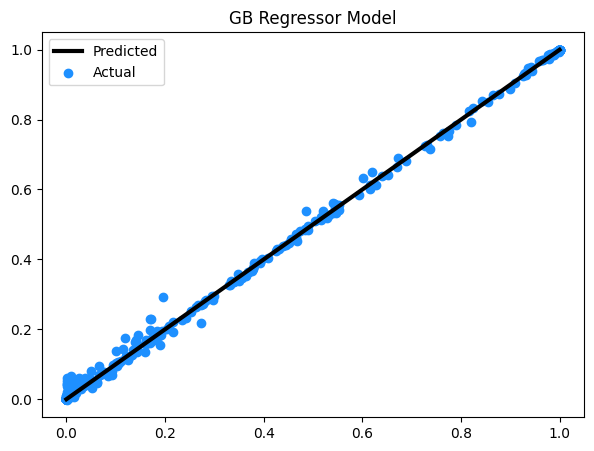

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='solid', lw=3, label='Predicted')
plt.scatter(y_test, y_pred_gbr, color='dodgerblue', marker='o', label='Actual')
plt.title('GB Regressor Model')
plt.legend()
plt.show()

**Ramdom Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred_rf = rf_regressor.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test,y_pred_rf)*100
nse_rf = nse(y_pred_rf,y_test)
nse_rf = "{:.1e}".format(nse_rf)
mbe_rf = mbe(y_pred_rf,y_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
metrics_rf = [mae_rf,nse_rf,mbe_rf,r2_rf,rmse_rf]

In [ ]:
table_metrics_rf = pd.DataFrame(metrics_rf)
table_metrics_rf.index = ["MAE","NSE","MBE","R2","RMSE"]
table_metrics_rf.columns = ["Random Forest Model"]
table_metrics_rf

,Random Forest Model
MAE,0.005527
NSE,1.1e-03
MBE,0.002677
R2,99.887388
RMSE,0.012255


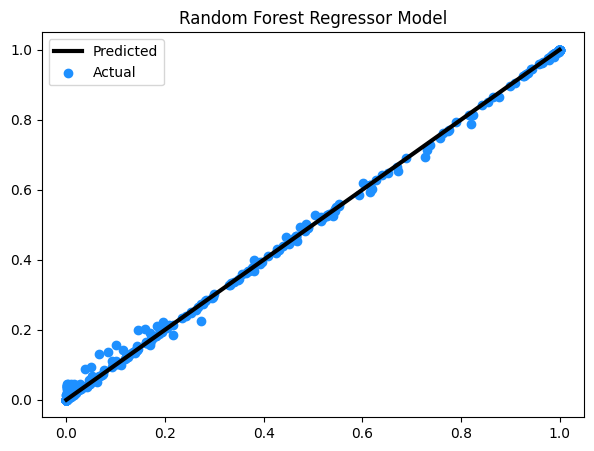

In [ ]:
plt.figure(figsize=(7,5))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='solid', lw=3, label='Predicted')
plt.scatter(y_test, y_pred_rf, color='dodgerblue', marker='o', label='Actual')
plt.title('Random Forest Regressor Model')
plt.legend()
plt.show()

**Bagging Regressor**

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
base_regressor = DecisionTreeRegressor()
bagging_regressor = BaggingRegressor(base_estimator=base_regressor, n_estimators=10, random_state=42)
bagging_regressor.fit(X_train, y_train)
y_pred_br = bagging_regressor.predict(X_test)
mae_br = mean_absolute_error(y_test, y_pred_br)
r2_br = r2_score(y_test,y_pred_br)*100
nse_br = nse(y_pred_br,y_test)
nse_br = "{:.1e}".format(nse_br)
mbe_br = mbe(y_pred_br,y_test)
rmse_br = np.sqrt(mean_squared_error(y_test, y_pred_br))
metrics_br = [mae_br,nse_br,mbe_br,r2_br,rmse_br]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
table_metrics_br = pd.DataFrame(metrics_br)
table_metrics_br.index = ["MAE","NSE","MBE","R2","RMSE"]
table_metrics_br.columns = ["Bagging Regressor Model"]
table_metrics_br

,Bagging Regressor Model
MAE,0.006836
NSE,1.8e-03
MBE,0.002635
R2,99.824385
RMSE,0.015304


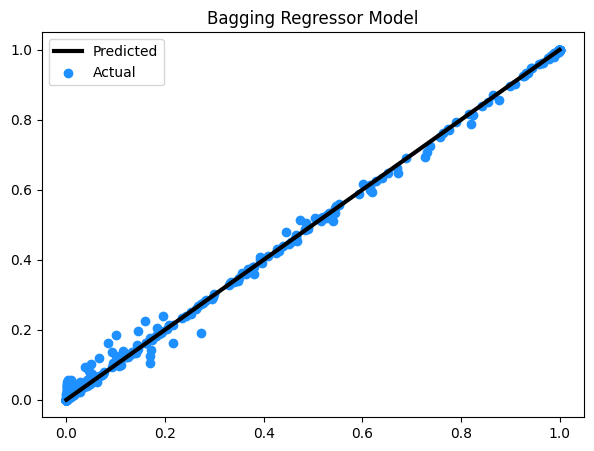

In [ ]:
plt.figure(figsize=(7,5))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='solid', lw=3, label='Predicted')
plt.scatter(y_test, y_pred_br, color='dodgerblue', marker='o', label='Actual')
plt.title('Bagging Regressor Model')
plt.legend()
plt.show()

**K Nearest Neighbor Regressor**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=5,weights="distance")
knn_regressor.fit(X_train, y_train)
y_pred_knn = knn_regressor.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test,y_pred_knn)*100
nse_knn = nse(y_pred_knn,y_test)
nse_knn = "{:.1e}".format(nse_knn)
mbe_knn = mbe(y_pred_knn,y_test)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
metrics_knn = [mae_knn,nse_knn,mbe_knn,r2_knn,rmse_knn]

In [ ]:
table_metrics_knn = pd.DataFrame(metrics_knn)
table_metrics_knn.index = ["MAE","NSE","MBE","R2","RMSE"]
table_metrics_knn.columns = ["KNN Model"]
table_metrics_knn

,KNN Model
MAE,0.012914
NSE,3.7e-03
MBE,-0.002184
R2,99.634346
RMSE,0.022083


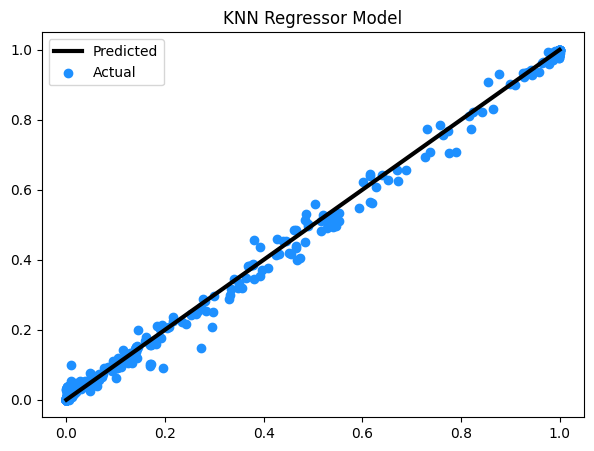

In [ ]:
plt.figure(figsize=(7,5))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='solid', lw=3, label='Predicted')
plt.scatter(y_test, y_pred_knn, color='dodgerblue', marker='o', label='Actual')
plt.title('KNN Regressor Model')
plt.legend()
plt.show()

**Averaging Model**

In [ ]:
y_pred_avg = (y_pred_rf + y_pred_br + y_pred_gbr) / 3
mse_avg = mean_squared_error(y_test, y_pred_avg)
mae_avg = mean_absolute_error(y_test, y_pred_avg)
r2_avg = r2_score(y_test,y_pred_avg)*100
nse_avg = nse(y_pred_avg,y_test)
nse_avg = "{:.1e}".format(nse_avg)
mbe_avg = mbe(y_pred_avg,y_test)
rmse_avg = np.sqrt(mean_squared_error(y_test, y_pred_avg))
metrics_avg = [mae_avg,nse_avg,mbe_avg,r2_avg,rmse_avg]

In [ ]:
table_metrics_avg = pd.DataFrame(metrics_avg)
table_metrics_avg.index = ["MAE","NSE","MBE","R2","RMSE"]
table_metrics_avg.columns = ["Averaging Model"]
table_metrics_avg

,Averaging Model
MAE,0.005621
NSE,1.1e-03
MBE,0.002734
R2,99.892023
RMSE,0.012


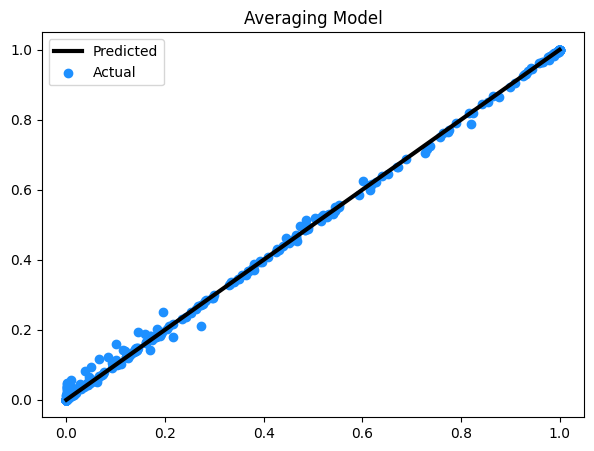

In [ ]:
plt.figure(figsize=(7,5))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='solid', lw=3, label='Predicted')
plt.scatter(y_test, y_pred_avg, color='dodgerblue', marker='o', label='Actual')
plt.title('Averaging Model')
plt.legend()
plt.show()

In [ ]:
seed = 13
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

**Deep Nueral Network**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model_dnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
optimizer = Adam(lr=0.0001)
model_dnn.compile(optimizer=optimizer,loss="mean_squared_error")
history_dnn = model_dnn.fit(X_train, y_train, epochs=50, batch_size=64,validation_split=0.85)
y_pred_dnn = model_dnn.predict(X_test)

mse_dnn = mean_squared_error(y_test, y_pred_dnn)
mae_dnn = mean_absolute_error(y_test, y_pred_dnn)
r2_dnn = r2_score(y_test,y_pred_dnn)*100
nse_dnn = nse(y_pred_dnn,y_test)
nse_dnn = "{:.1e}".format(nse_dnn)
mbe_dnn = mbe(y_pred_dnn,y_test)
rmse_dnn = np.sqrt(mean_squared_error(y_test, y_pred_dnn))
metrics_dnn = [mae_dnn,nse_dnn,mbe_dnn,r2_dnn,rmse_dnn]

Epoch 1/50
20/20 [==============================] - 3s 55ms/step - loss: 0.0748 - val_loss: 0.0173
Epoch 2/50
20/20 [==============================] - 0s 25ms/step - loss: 0.0121 - val_loss: 0.0063
Epoch 3/50
20/20 [==============================] - 1s 44ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 4/50
20/20 [==============================] - 1s 45ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 5/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 6/50
20/20 [==============================] - 1s 37ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 7/50
20/20 [==============================] - 1s 46ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 8/50
20/20 [==============================] - 1s 26ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 9/50
20/20 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/50
20/20 [==============================] - 1s 48ms/step - loss: 9.6403e-04 - val_loss: 9.8304e-04
E

In [ ]:
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3073 (12.00 KB)
Trainable params: 3073 (12.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


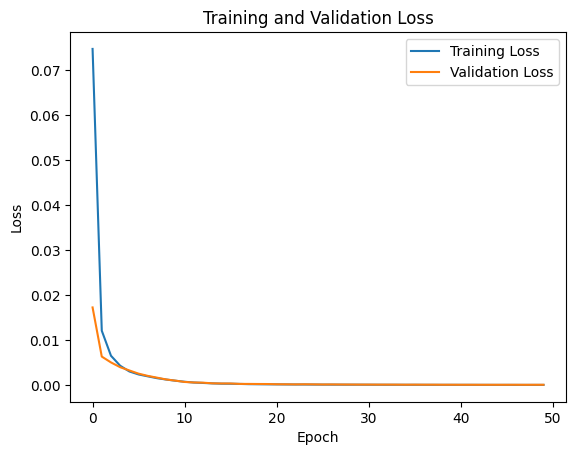

In [ ]:
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

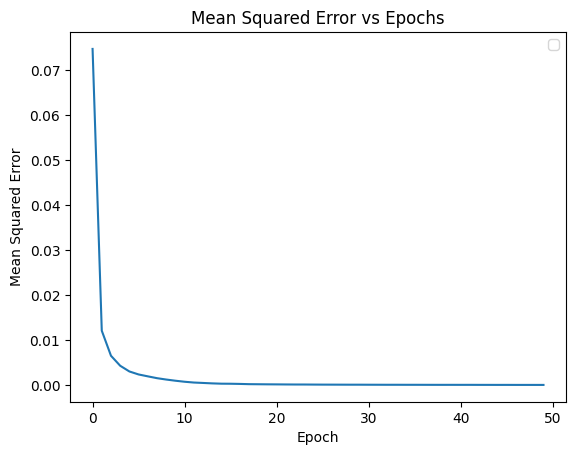

In [ ]:
plt.plot(history_dnn.history['loss'])
plt.title('Mean Squared Error vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
table_metrics_dnn = pd.DataFrame(metrics_dnn)
table_metrics_dnn.index = ["MAE","NSE","MBE","R2","RMSE"]
table_metrics_dnn.columns = ["DNN Model"]
table_metrics_dnn

,DNN Model
MAE,0.004578
NSE,8.2e+02
MBE,0.001442
R2,99.966386
RMSE,0.006695


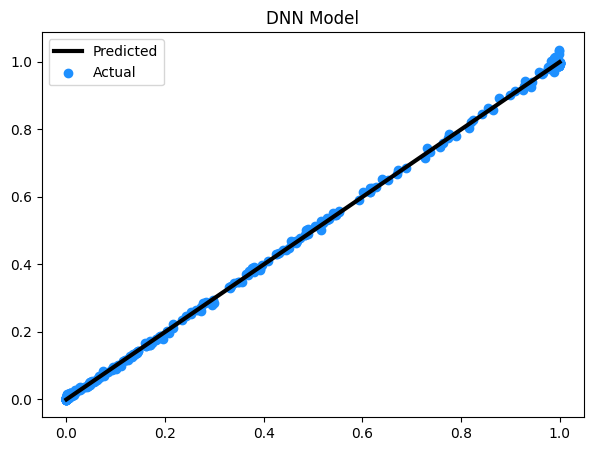

In [ ]:
plt.figure(figsize=(7,5))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='solid', lw=3, label='Predicted')
plt.scatter(y_test, y_pred_dnn, color='dodgerblue', marker='o', label='Actual')
plt.title('DNN Model')
plt.legend()
plt.show()

**LSTM MODEL**

In [ ]:
seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras.layers import LSTM
from keras import regularizers
model_lstm = Sequential()
model_lstm.add(LSTM(128,activation='relu',input_shape=(X_train.shape[1],1)))
model_lstm.add(Dense(32,activation='relu'))
model_lstm.add(Dense(32,activation='relu'))
model_lstm.add(Dense(1))
optimizer_lstm = Adam(lr=0.0001)
model_lstm.compile(optimizer=optimizer_lstm, loss='mean_squared_error')
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=64,validation_split=0.85)
y_pred_lstm = model_lstm.predict(X_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm) * 100
nse_lstm = nse(y_pred_lstm, y_test)
nse_lstm = "{:.1e}".format(nse_lstm)
mbe_lstm = mbe(y_pred_lstm, y_test)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
'''print("Mean Absolute Error:", mae_lstm)
print("Root Mean Squared Error:", rmse_lstm)
print("R2 Score:", r2_lstm)
print("NSE:", nse_lstm)
print("MBE:", mbe_lstm)'''
metrics_lstm = [mae_lstm,nse_lstm,mbe_lstm,r2_lstm,rmse_lstm]

Epoch 1/50
20/20 [==============================] - 7s 161ms/step - loss: 0.1954 - val_loss: 0.0813
Epoch 2/50
20/20 [==============================] - 2s 90ms/step - loss: 0.0890 - val_loss: 0.0608
Epoch 3/50
20/20 [==============================] - 1s 76ms/step - loss: 0.0602 - val_loss: 0.0246
Epoch 4/50
20/20 [==============================] - 1s 57ms/step - loss: 0.0271 - val_loss: 0.0056
Epoch 5/50
20/20 [==============================] - 1s 46ms/step - loss: 0.0144 - val_loss: 0.0055
Epoch 6/50
20/20 [==============================] - 1s 41ms/step - loss: 0.0096 - val_loss: 0.0057
Epoch 7/50
20/20 [==============================] - 1s 46ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 8/50
20/20 [==============================] - 1s 40ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 9/50
20/20 [==============================] - 1s 40ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/50
20/20 [==============================] - 1s 46ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 11

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 71777 (280.38 KB)
Trainable params: 71777 (280.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


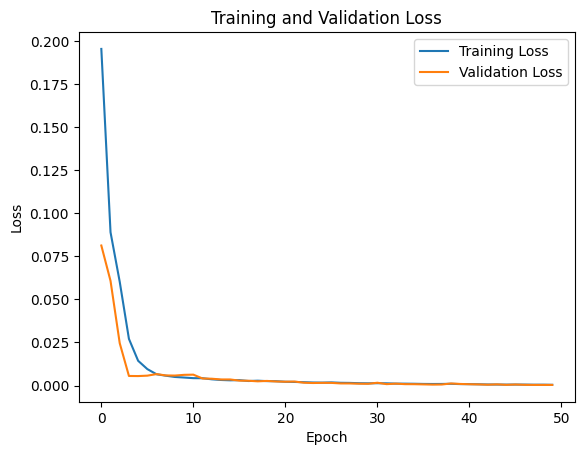

In [ ]:
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

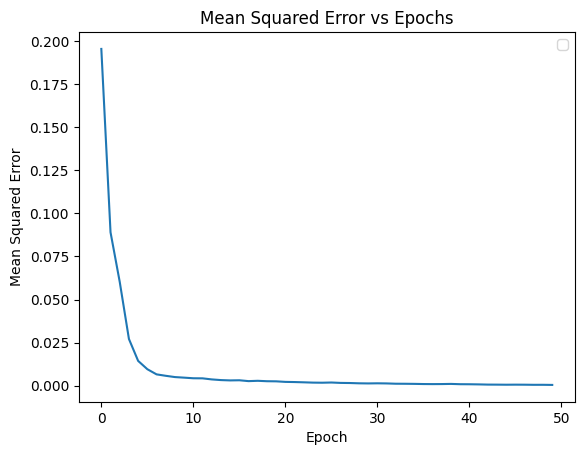

In [ ]:
plt.plot(history_lstm.history['loss'])
plt.title('Mean Squared Error vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
table_metrics_lstm = pd.DataFrame(metrics_lstm)
table_metrics_lstm.index = ["MAE","NSE","MBE","R2","RMSE"]
table_metrics_lstm.columns = ["LSTM Model"]
table_metrics_lstm

,LSTM Model
MAE,0.010925
NSE,8.1e+02
MBE,0.001764
R2,99.820728
RMSE,0.015462


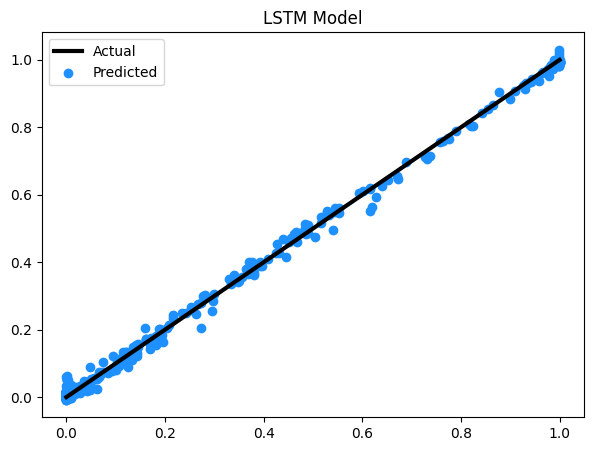

In [ ]:
plt.figure(figsize=(7,5))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='solid', lw=3, label='Actual')
plt.scatter(y_test, y_pred_lstm, color='dodgerblue', marker='o', label='Predicted')
plt.title('LSTM Model')
plt.legend()
plt.show()

**SFS-PSO OPTIMIZER**

In [ ]:
'''def fitness_function(x):
    return np.sum(x ** 2, axis=1)'''

'def fitness_function(x):\n    return np.sum(x ** 2, axis=1)'

In [ ]:
'''def update_velocity(x, v, p_best, g_best, omega, c1, c2, r1, r2):
    return omega * v + c1 * r1 * (p_best - x) + c2 * r2 * (g_best - x)'''

'def update_velocity(x, v, p_best, g_best, omega, c1, c2, r1, r2):\n    return omega * v + c1 * r1 * (p_best - x) + c2 * r2 * (g_best - x)'

In [ ]:
'''def apply_diffusion_process(particles, p_best, v_best, beta, beta_prime, sigma):
    gaussian_noise = np.random.normal(0, sigma, particles.shape)
    return gaussian_noise + beta * p_best - beta_prime * v_best'''

'def apply_diffusion_process(particles, p_best, v_best, beta, beta_prime, sigma):\n    gaussian_noise = np.random.normal(0, sigma, particles.shape)\n    return gaussian_noise + beta * p_best - beta_prime * v_best'

In [ ]:
'''def sfs_pso(particles, n, dim, max_iterations, omega, c1, c2, r1, r2, beta, beta_prime, sigma):
    velocities = np.random.rand(n, dim)
    p_best = particles.copy()
    g_best_index = np.argmin(fitness_function(particles))
    g_best = particles[g_best_index]
    g_best_fitness = np.min(fitness_function(particles))
    t = 0
    while t < max_iterations:
        for i in range(n):
            velocities[i] = update_velocity(particles[i], velocities[i], p_best[i], g_best, omega, c1, c2, r1, r2)
            particles[i] += velocities[i]
        for i in range(n):
            p_best[i] = particles[i]
        diffused_particles = apply_diffusion_process(particles, p_best, g_best, beta, beta_prime, sigma)
        particles_fitness = fitness_function(particles)
        diffused_particles_fitness = fitness_function(diffused_particles)
        for i in range(n):
            if diffused_particles_fitness[i] < particles_fitness[i]:
                particles[i] = diffused_particles[i]
        g_best_index = np.argmin(fitness_function(particles))
        new_g_best = particles[g_best_index]
        new_g_best_fitness = np.min(fitness_function(particles))

        if new_g_best_fitness < g_best_fitness:
            g_best = new_g_best
            g_best_fitness = new_g_best_fitness

        t += 1
    return g_best'''

'def sfs_pso(particles, n, dim, max_iterations, omega, c1, c2, r1, r2, beta, beta_prime, sigma):\n    velocities = np.random.rand(n, dim)\n    p_best = particles.copy()\n    g_best_index = np.argmin(fitness_function(particles))\n    g_best = particles[g_best_index]\n    g_best_fitness = np.min(fitness_function(particles))\n    t = 0\n    while t < max_iterations:\n        for i in range(n):\n            velocities[i] = update_velocity(particles[i], velocities[i], p_best[i], g_best, omega, c1, c2, r1, r2)\n            particles[i] += velocities[i]\n        for i in range(n):\n            p_best[i] = particles[i]\n        diffused_particles = apply_diffusion_process(particles, p_best, g_best, beta, beta_prime, sigma)\n        particles_fitness = fitness_function(particles)\n        diffused_particles_fitness = fitness_function(diffused_particles)\n        for i in range(n):\n            if diffused_particles_fitness[i] < particles_fitness[i]:\n                particles[i] = diffused_part

In [ ]:
'''n_particles = X.shape[0]
dimension = X.shape[1]
max_iterations = 100
omega = 0.5
c1 = 1.5
c2 = 1.5
r1 = np.round(random.random(), 10)
r2 = np.round(random.random(), 10)
beta = np.random.rand()
beta_prime = np.random.rand()
sigma = 0.1
sfs_pso(X, n_particles, dimension, max_iterations, omega, c1, c2, r1, r2, beta, beta_prime, sigma)'''

'n_particles = X.shape[0]\ndimension = X.shape[1]\nmax_iterations = 100\nomega = 0.5\nc1 = 1.5\nc2 = 1.5\nr1 = np.round(random.random(), 10)\nr2 = np.round(random.random(), 10)\nbeta = np.random.rand()\nbeta_prime = np.random.rand()\nsigma = 0.1\nsfs_pso(X, n_particles, dimension, max_iterations, omega, c1, c2, r1, r2, beta, beta_prime, sigma)'

**LSTM WITH PSO OPTIMIZER**

In [ ]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
def lstm_pso_optimization(params):
    model = keras.Sequential([
        keras.layers.LSTM(int(params[0]), activation='relu', input_shape=(X_train.shape[1],1)),
        keras.layers.Dropout(int(params[1])),
        keras.layers.Dense(int(params[2]), activation='relu'),
        keras.layers.Dropout(int(params[3])),
        keras.layers.Dense(int(params[4]), activation='relu'),
        keras.layers.Dense(1),
    ])
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=64)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred.round())
    return r2

In [ ]:
from pyswarm import pso
import keras
lstm_lb = [8,0.1,8,0.1,8]
lstm_ub = [32,0.5,32,0.5,32]
best_params_lstm, _ = pso(lstm_pso_optimization,lstm_lb,lstm_ub,swarmsize=10,maxiter=5)
lstm_neurons_layer1, lstm_dropout1, lstm_neurons_layer2, lstm_dropout2, lstm_neurons_layer3 = best_params_lstm

Streaming output truncated to the last 5000 lines.
131/131 [==============================] - 1s 5ms/step - loss: 4.4126e-04
Epoch 27/50
131/131 [==============================] - 1s 5ms/step - loss: 4.5274e-04
Epoch 28/50
131/131 [==============================] - 1s 5ms/step - loss: 3.8972e-04
Epoch 29/50
131/131 [==============================] - 1s 5ms/step - loss: 4.0655e-04
Epoch 30/50
131/131 [==============================] - 1s 5ms/step - loss: 4.0264e-04
Epoch 31/50
131/131 [==============================] - 1s 5ms/step - loss: 4.1814e-04
Epoch 32/50
131/131 [==============================] - 1s 5ms/step - loss: 3.8124e-04
Epoch 33/50
131/131 [==============================] - 1s 5ms/step - loss: 4.3394e-04
Epoch 34/50
131/131 [==============================] - 1s 5ms/step - loss: 3.6876e-04
Epoch 35/50
131/131 [==============================] - 1s 5ms/step - loss: 3.7209e-04
Epoch 36/50
131/131 [==============================] - 1s 5ms/step - loss: 3.4014e-04
Epoch 37/50
131

In [ ]:
from keras.layers import Dropout
model_lstm_pso = Sequential()
model_lstm_pso.add(LSTM(units=int(lstm_neurons_layer1), activation='relu', input_shape=(X_train.shape[1], 1), recurrent_dropout=0.2))
model_lstm_pso.add(Dropout(int(lstm_dropout1)))
model_lstm_pso.add(Dense(units=int(lstm_neurons_layer2), activation='relu'))
model_lstm_pso.add(Dropout(int(lstm_dropout2)))
model_lstm_pso.add(Dense(units=int(lstm_neurons_layer3), activation='relu'))
model_lstm_pso.add(Dense(1))
optimizer_lstm_pso = Adam(lr=0.001)
model_lstm_pso.compile(optimizer=optimizer_lstm_pso, loss='mean_squared_error')
history_lstm_pso = model_lstm_pso.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
y_pred_lstm_pso = model_lstm_pso.predict(X_test)
mse_lstm_pso = mean_squared_error(y_test, y_pred_lstm_pso)
mae_lstm_pso = mean_absolute_error(y_test, y_pred_lstm_pso)
r2_lstm_pso = r2_score(y_test, y_pred_lstm_pso) * 100
nse_lstm_pso = nse(y_pred_lstm_pso, y_test)
nse_lstm_pso = "{:.1e}".format(nse_lstm_pso)
mbe_lstm_pso = mbe(y_pred_lstm_pso, y_test)
rmse_lstm_pso = np.sqrt(mean_squared_error(y_test, y_pred_lstm_pso))
metrics_lstm_pso = [mae_lstm_pso,nse_lstm_pso,mbe_lstm_pso,r2_lstm_pso,rmse_lstm_pso]

Epoch 1/100
209/209 [==============================] - 6s 11ms/step - loss: 0.0632 - val_loss: 0.0074
Epoch 2/100
209/209 [==============================] - 2s 7ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 3/100
209/209 [==============================] - 2s 8ms/step - loss: 0.0069 - val_loss: 0.0036
Epoch 4/100
209/209 [==============================] - 2s 8ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 5/100
209/209 [==============================] - 2s 8ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 6/100
209/209 [==============================] - 3s 13ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 7/100
209/209 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 8/100
209/209 [==============================] - 2s 8ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/100
209/209 [==============================] - 2s 7ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 10/100
209/209 [==============================] - 2s 8ms/step - loss: 0.0025 - val

In [ ]:
model_lstm_pso.summary()

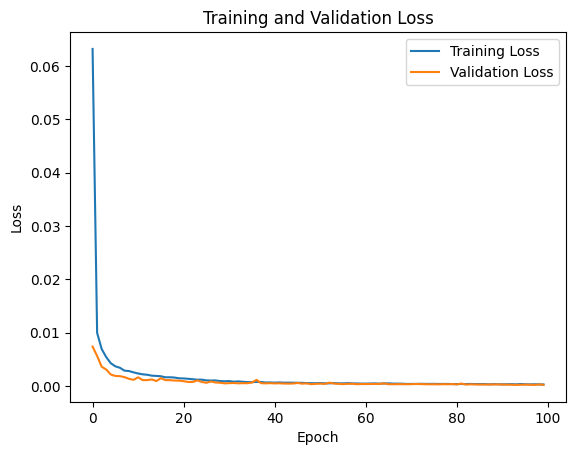

In [ ]:
plt.plot(history_lstm_pso.history['loss'], label='Training Loss')
plt.plot(history_lstm_pso.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

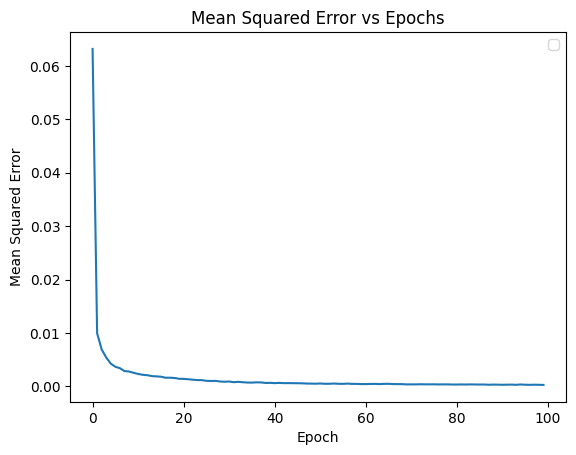

In [ ]:
plt.plot(history_lstm_pso.history['loss'])
plt.title('Mean Squared Error vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
table_metrics_lstm_pso = pd.DataFrame(metrics_lstm_pso)
table_metrics_lstm_pso.index = ["MAE","NSE","MBE","R2","RMSE"]
table_metrics_lstm_pso.columns = ["PSO-LSTM"]
table_metrics_lstm_pso

,PSO-LSTM
MAE,0.010297
NSE,8.1e+02
MBE,0.00429
R2,99.781829
RMSE,0.017058


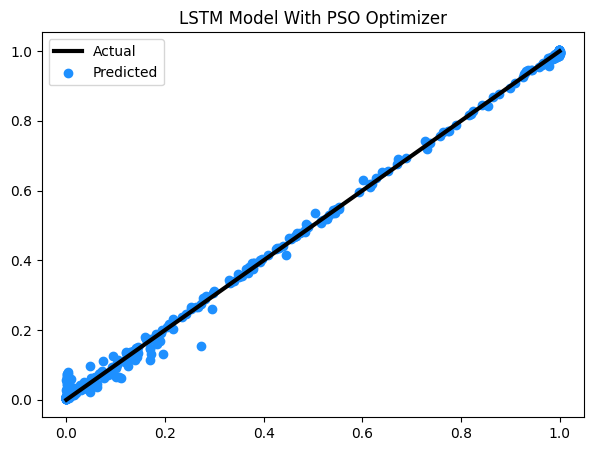

In [ ]:
plt.figure(figsize=(7,5))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='solid', lw=3, label='Actual')
plt.scatter(y_test, y_pred_lstm_pso, color='dodgerblue', marker='o', label='Predicted')
plt.title('LSTM Model With PSO Optimizer')
plt.legend()
plt.show()

**GRU** **MODEL**

In [ ]:
seed = 57
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from keras.layers import GRU
model_gru = Sequential()
model_gru.add(GRU(units=32, activation='relu', input_shape=(X_train.shape[1], 1)))
model_gru.add(Dense(units=16, activation='relu'))
model_gru.add(Dense(units=8, activation='relu'))
model_gru.add(Dense(1))
optimizer_gru = Adam(lr=0.001)
model_gru.compile(optimizer=optimizer_gru, loss='mean_squared_error')
history_gru = model_gru.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)
y_pred_gru = model_gru.predict(X_test)
mse_gru = mean_squared_error(y_test, y_pred_gru)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru) * 100
nse_gru = nse(y_pred_gru, y_test)
nse_gru = "{:.1e}".format(nse_gru)
mbe_gru = mbe(y_pred_gru, y_test)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
metrics_gru = [mae_gru,nse_gru,mbe_gru,r2_gru,rmse_gru]

Epoch 1/50
105/105 [==============================] - 4s 10ms/step - loss: 0.1050 - val_loss: 0.0175
Epoch 2/50
105/105 [==============================] - 1s 6ms/step - loss: 0.0135 - val_loss: 0.0130
Epoch 3/50
105/105 [==============================] - 1s 6ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 4/50
105/105 [==============================] - 1s 6ms/step - loss: 0.0082 - val_loss: 0.0090
Epoch 5/50
105/105 [==============================] - 1s 6ms/step - loss: 0.0069 - val_loss: 0.0052
Epoch 6/50
105/105 [==============================] - 1s 6ms/step - loss: 0.0056 - val_loss: 0.0041
Epoch 7/50
105/105 [==============================] - 1s 6ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 8/50
105/105 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 9/50
105/105 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 10/50
105/105 [==============================] - 1s 6ms/step - loss: 0.0020 - val_loss: 0.001

In [ ]:
model_gru.summary()

In [ ]:
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history_gru.history['loss'])
plt.title('Mean Squared Error vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
table_metrics_gru = pd.DataFrame(metrics_gru)
table_metrics_gru.index = ["MAE","NSE","MBE","R2","RMSE"]
table_metrics_gru.columns = ["GRU"]
table_metrics_gru

In [ ]:
plt.figure(figsize=(7,5))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='solid', lw=3, label='Actual')
plt.scatter(y_test, y_pred_gru, color='dodgerblue', marker='o', label='Predicted')
plt.title('GRU MODEL')
plt.legend()
plt.show()

**GRU MODEL WITH PSO**

In [ ]:
seed = 18
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
def pso_optimization(params):
    model = keras.Sequential([
        keras.layers.GRU(int(params[0]), activation='relu', input_shape=(X_train.shape[1],1)),
        keras.layers.Dense(int(params[1]), activation='relu'),
        keras.layers.Dense(int(params[2]), activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=64)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred.round())
    return r2

In [ ]:
from pyswarm import pso
import keras
lb = [8,8,8]
ub = [32,32,32]
best_params, _ = pso(pso_optimization,lb,ub,swarmsize=10,maxiter=5)
neurons_layer1, neurons_layer2, neurons_layer3 = best_params

Streaming output truncated to the last 5000 lines.
131/131 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 27/50
131/131 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 28/50
131/131 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 29/50
131/131 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 30/50
131/131 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 31/50
131/131 [==============================] - 1s 5ms/step - loss: 0.0010
Epoch 32/50
131/131 [==============================] - 1s 5ms/step - loss: 9.4874e-04
Epoch 33/50
131/131 [==============================] - 1s 4ms/step - loss: 9.9770e-04
Epoch 34/50
131/131 [==============================] - 1s 6ms/step - loss: 9.0048e-04
Epoch 35/50
131/131 [==============================] - 1s 5ms/step - loss: 8.0899e-04
Epoch 36/50
131/131 [==============================] - 1s 5ms/step - loss: 9.2392e-04
Epoch 37/50
131/131 [==================

In [ ]:
from keras.layers import GRU
model_gru_pso = Sequential()
model_gru_pso.add(GRU(units=int(neurons_layer1), activation='relu', input_shape=(X_train.shape[1], 1)))
model_gru_pso.add(Dense(units=int(neurons_layer2), activation='relu'))
model_gru_pso.add(Dense(units=int(neurons_layer2), activation='relu'))
model_gru_pso.add(Dense(1))
optimizer_gru_pso = Adam(lr=0.001)
model_gru_pso.compile(optimizer=optimizer_gru_pso, loss='mean_squared_error')
history_gru_pso = model_gru_pso.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)
y_pred_gru_pso = model_gru_pso.predict(X_test)
mse_gru_pso = mean_squared_error(y_test, y_pred_gru_pso)
mae_gru_pso = mean_absolute_error(y_test, y_pred_gru_pso)
r2_gru_pso = r2_score(y_test, y_pred_gru_pso) * 100
nse_gru_pso = nse(y_pred_gru_pso, y_test)
nse_gru_pso = "{:.1e}".format(nse_gru_pso)
mbe_gru_pso = mbe(y_pred_gru_pso, y_test)
rmse_gru_pso = np.sqrt(mean_squared_error(y_test, y_pred_gru_pso))
metrics_gru_pso = [mae_gru_pso,nse_gru_pso,mbe_gru_pso,r2_gru_pso,rmse_gru_pso]

Epoch 1/50
105/105 [==============================] - 2s 7ms/step - loss: 0.1088 - val_loss: 0.0251
Epoch 2/50
105/105 [==============================] - 0s 5ms/step - loss: 0.0155 - val_loss: 0.0160
Epoch 3/50
105/105 [==============================] - 1s 5ms/step - loss: 0.0139 - val_loss: 0.0152
Epoch 4/50
105/105 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0133
Epoch 5/50
105/105 [==============================] - 0s 5ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 6/50
105/105 [==============================] - 0s 5ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 7/50
105/105 [==============================] - 1s 6ms/step - loss: 0.0090 - val_loss: 0.0076
Epoch 8/50
105/105 [==============================] - 1s 7ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 9/50
105/105 [==============================] - 1s 8ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 10/50
105/105 [==============================] - 1s 5ms/step - loss: 0.0065 - val_loss: 0.0054

In [ ]:
model_gru_pso.summary()

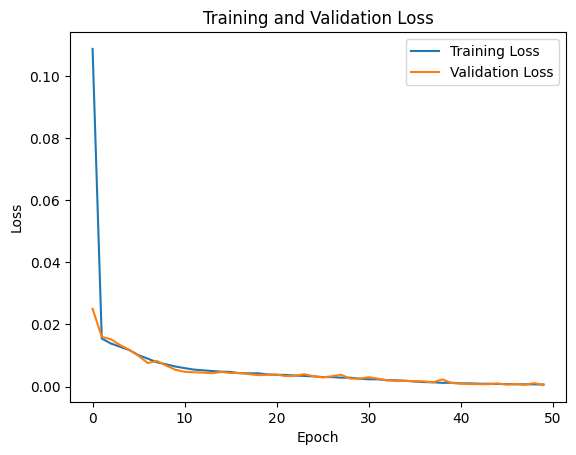

In [ ]:
plt.plot(history_gru_pso.history['loss'], label='Training Loss')
plt.plot(history_gru_pso.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

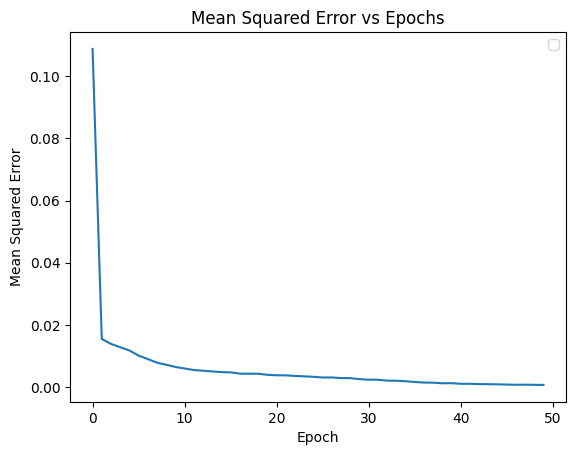

In [ ]:
plt.plot(history_gru_pso.history['loss'])
plt.title('Mean Squared Error vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
table_metrics_gru_pso = pd.DataFrame(metrics_gru_pso)
table_metrics_gru_pso.index = ["MAE","NSE","MBE","R2","RMSE"]
table_metrics_gru_pso.columns = ["PSO-GRU"]
table_metrics_gru_pso

,PSO-GRU
MAE,0.019505
NSE,8.0e+02
MBE,-0.001547
R2,99.504307
RMSE,0.025711


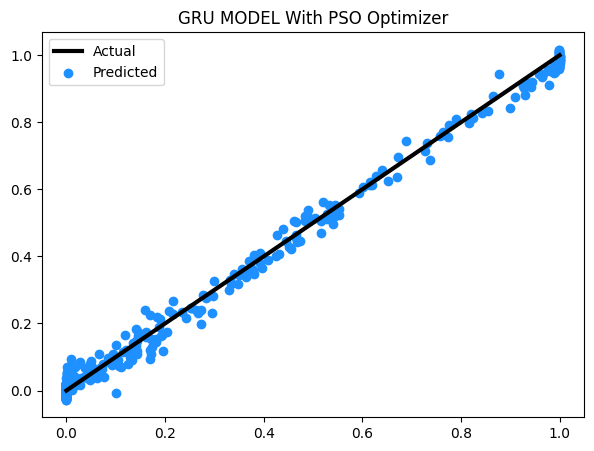

In [ ]:
plt.figure(figsize=(7,5))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='solid', lw=3, label='Actual')
plt.scatter(y_test, y_pred_gru_pso, color='dodgerblue', marker='o', label='Predicted')
plt.title('GRU MODEL With PSO Optimizer')
plt.legend()
plt.show()

**Overall Metrics Table**

In [ ]:
Metric = pd.DataFrame(columns=["MAE","NSE","MBE","R2","RMSE"],index=['DNN','KNN','LSTM','Averaging','RF Regressor','Bagging Regressor','Gradient Boosting Regrssor','PSO-LSTM','GRU','PSO-GRU'],data=[metrics_dnn,metrics_knn,metrics_lstm,metrics_avg,metrics_rf,metrics_br,metrics_gbr,metrics_lstm_pso,metrics_gru,metrics_gru_pso])
Metric

,MAE,NSE,MBE,R2,RMSE
DNN,0.004578,8.2e+02,0.001442,99.966386,0.006695
KNN,0.012914,3.7e-03,-0.002184,99.634346,0.022083
LSTM,0.010925,8.1e+02,0.001764,99.820728,0.015462
Averaging,0.005621,1.1e-03,0.002734,99.892023,0.012000
RF Regressor,0.005527,1.1e-03,0.002677,99.887388,0.012255
Bagging Regressor,0.006836,1.8e-03,0.002635,99.824385,0.015304
Gradient Boosting Regrssor,0.006915,1.5e-03,0.002889,99.854969,0.013908
PSO-LSTM,0.010297,8.1e+02,0.004290,99.781829,0.017058
GRU,0.004112,8.2e+02,0.002147,99.974307,0.005854
PSO-GRU,0.032261,7.8e+02,0.014711,98.529714,0.044281
